In [1]:
pip install --upgrade albumentations


     |████████████████████████████████| 98 kB 3.4 MB/s 
     |████████████████████████████████| 37.1 MB 48 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


## Defining the model

In [2]:
import dataset

### Architecture
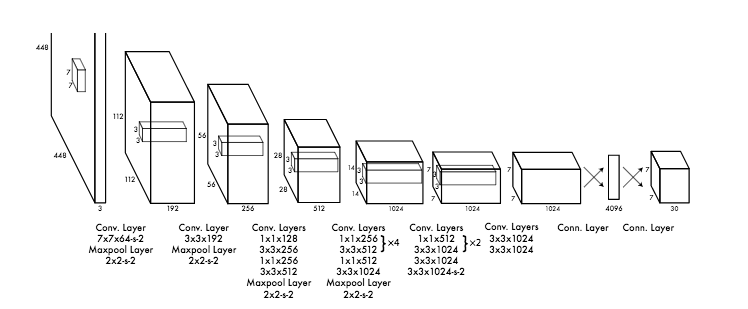

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# constants
# size of grid
S = 7
# number of bounding boxes per grid cell
B = 2
# no classes
C = 20


class darknet(nn.Module):
    def __init__(self, pretrain=False):
        super(darknet, self).__init__()
        
        self.convolutional_layers = self._make_convolutional_layers()
        
        self.fc_layers = nn.Sequential(
            nn.Linear(1024 * S * S, 4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S * S * (B * 5 + C)),
        )

    def forward(self, x):
        # for loop with print size for debugging
        for layer in self.convolutional_layers:
            x = layer(x)
            print(x.size())
            
#         x = self.convolutional_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        x = x.view(x.size(0), S, S,  B * 5 + C)
        return x
    
    def _make_convolutional_layers(self, batch_norm=True):
        convolutional_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(64, 192, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            # 56x56x192
#             [1, 192, 56, 56]
            
            nn.Conv2d(192, 128, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, stride=2),
            
#             [1, 256, 28, 28]
            
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 512, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, stride=2),
            
#             [1, 1024, 14, 14]
            
            nn.Conv2d(1024, 512, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 512, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 1024, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            
#             [1, 1024, 7, 7]
            
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
        )
        return convolutional_layers


net = darknet()
print(net)

darknet(
  (convolutional_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1, inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.1, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.1, inplace=True)
    (10): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.1, inplace=True)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.1, inplace=True)
    (14): MaxPool2d(kernel_size=2, st

In [4]:
def test(net):
  x = torch.randn(2, 3, 448, 448)
  return net(x)

In [5]:
test(net)

torch.Size([2, 64, 224, 224])
torch.Size([2, 64, 224, 224])
torch.Size([2, 64, 112, 112])
torch.Size([2, 192, 112, 112])
torch.Size([2, 192, 112, 112])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([2, 192, 56, 56])
torch.Size([2, 128, 56, 56])
torch.Size([2, 128, 56, 56])
torch.Size([2, 256, 56, 56])
torch.Size([2, 256, 56, 56])
torch.Size([2, 256, 56, 56])
torch.Size([2, 256, 56, 56])
torch.Size([2, 512, 56, 56])
torch.Size([2, 512, 56, 56])
torch.Size([2, 512, 28, 28])
torch.Size([2, 256, 28, 28])
torch.Size([2, 256, 28, 28])
torch.Size([2, 512, 28, 28])
torch.Size([2, 512, 28, 28])
torch.Size([2, 256, 28, 28])
torch.Size([2, 256, 28, 28])
torch.Size([2, 512, 28, 28])
torch.Size([2, 512, 28, 28])
torch.Size([2, 256, 28, 28])
torch.Size([2, 256, 28, 28])
torch.Size([2, 512, 28, 28])
torch.Size([2, 512, 28, 28])
torch.Size([2, 256, 28, 28])
torch.Size([2, 256, 28, 28])
torch.Size([2, 512, 28, 28])
torch.Size([2, 512, 28, 28])
torch.Size([2, 512, 28, 28])
torch.Size([2, 512, 28, 28])
torch.Size([2, 1024, 28, 28])
torch.Size([2, 1024, 28, 28])
torch.Size([2, 1024, 14, 14])
torch.Size([2, 512, 14, 14])
torch.Size([2, 512, 14, 14])
torch.Size([2, 1024, 14, 14])
torch.Size

tensor([[[[-1.0719e-02, -1.4485e-02, -4.5318e-03,  ..., -8.0810e-03,
            3.5837e-04, -1.2208e-02],
          [-6.9190e-04, -9.8104e-03,  1.0599e-03,  ..., -6.5810e-04,
           -1.5298e-02,  1.2968e-03],
          [-8.6725e-03,  1.6007e-02,  6.1096e-03,  ..., -1.1066e-02,
           -1.0925e-02,  5.2426e-03],
          ...,
          [ 4.7120e-03,  1.3400e-02, -9.0722e-03,  ...,  1.6076e-03,
           -2.2706e-03, -1.3352e-02],
          [ 7.3119e-03,  5.5480e-03, -9.2348e-04,  ..., -5.0049e-03,
            7.9755e-03,  1.3322e-02],
          [ 1.4400e-02,  1.0718e-02, -8.4855e-04,  ...,  4.1188e-04,
            6.2642e-03, -1.4444e-02]],

         [[-7.9008e-03, -1.0767e-02,  4.0230e-03,  ...,  3.4022e-03,
            9.3675e-03,  8.3405e-03],
          [-2.4858e-03,  1.3343e-02,  7.7690e-03,  ..., -1.0865e-02,
            2.7832e-03, -1.4007e-02],
          [ 2.1885e-03,  4.8397e-03,  8.5779e-03,  ..., -3.1311e-03,
            1.0309e-02,  9.3159e-03],
          ...,
     

### Training

To avoid overfitting:
- dropout is used with rate 0.5 after the first connected layer
- extensive data augmentation is used - random scaling and translations of up to 20% of the original image size
- also randomly adjust the exposure and saturation of the image by up to factor of 1.5 in the HSV color space

##### Constants

In [11]:
# from the paper
MOMENTUM = 0.9
EPOCHS = 10
DECAY = 0.0005
# model is trained with 135 epochs
# first 5 epochs from 0.001 to 0.1
# 75 epochs 0.01 epochs
# 30 epochs 0.001
# 30 epochs 0.0001
LEARNING_RATE = 0.01
LAMBDA_NOOBJ = 0.5
LAMBDA_COORD = 5
SMOOTH = 1e-6

  0%|          | 0/460032000 [00:00<?, ?it/s]

Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data


  0%|          | 0/451020800 [00:00<?, ?it/s]

Extracting ./data/VOCtest_06-Nov-2007.tar to ./data
Feature batch shape for training: torch.Size([64, 3, 448, 448])
Labels batch shape for training: 64
Sample batch for training dataloader is presented below:


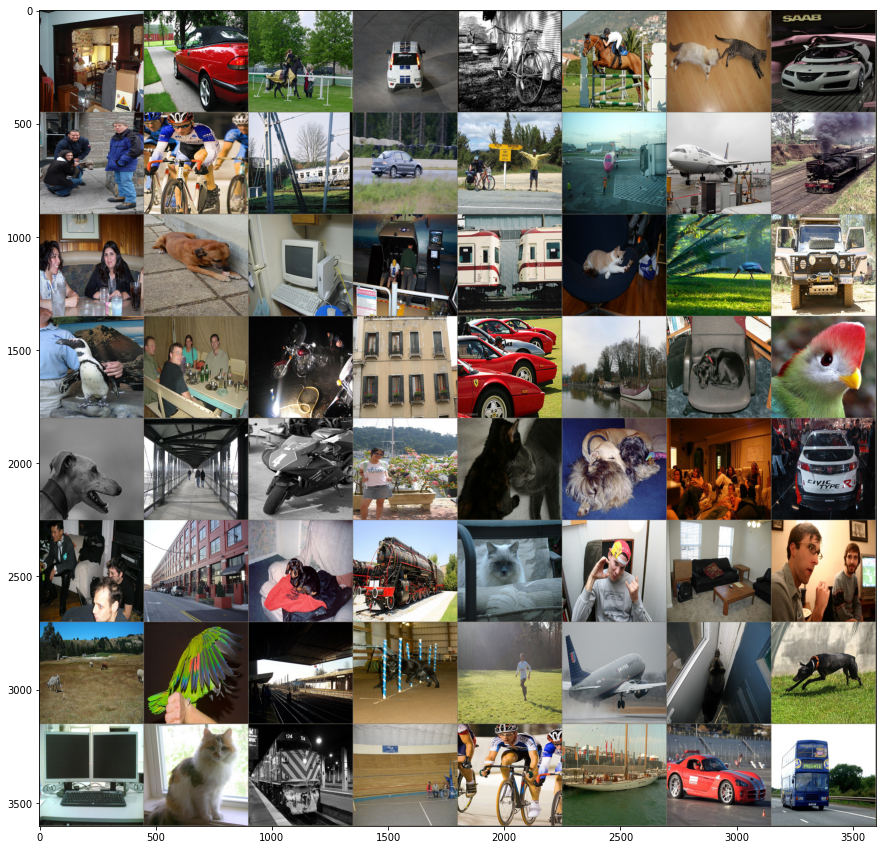

In [7]:
train_dl, test_dl = dataset.prepare_data()
 

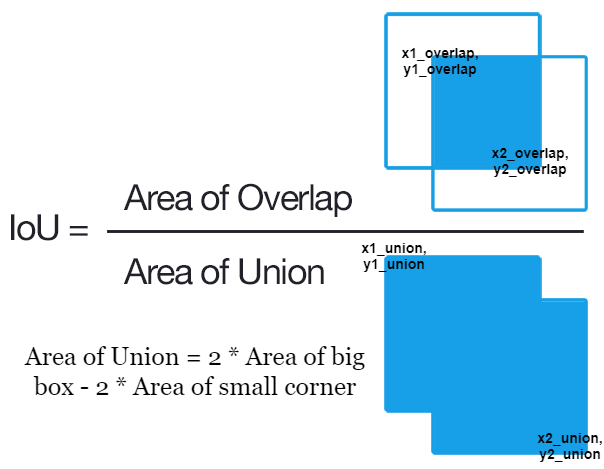

In [8]:
### TODO -> CHANGE TO WORK WITH TENSORS

def IOU(box_predicted, box_target):
  # I assume that the box is a list of 4 coordinates xmin, ymin, xmax, ymax
  # OVERLAP
  x1_overlap = max(box_predicted[0], box_target[0])
  y1_overlap = max(box_predicted[1], box_target[1])
  x2_overlap = min(box_predicted[2], box_target[2])
  y2_overlap = min(box_predicted[3], box_target[3])

  x1_union = min(box_predicted[0], box_target[0])
  y1_union = min(box_predicted[1], box_target[1])
  x2_union = max(box_predicted[2], box_target[2])
  y2_union = max(box_predicted[3], box_target[3])

  area_overlap = (x2_overlap - x1_overlap) * (y2_overlap - y1_overlap)
  area_union = (x2_union - x1_union) * (y2_union - y1_union) - 2 * (x1_overlap - x1_union) * (y2_union - y2_overlap)

  return area_overlap / area_union


In [9]:
print("reference value: 0")
print(IOU([0, 0, 0.5, 0.5], [0.5, 0.5, 1, 1]))
print("reference value: 0.25")
print(IOU([0, 0, 0.5, 0.5], [0, 0, 1, 1]))
print("reference value: 0.5")
print(IOU([0, 0, 0.5, 0.5], [0, 0, 0.5, 1]))


reference value: 0
0.0
reference value: 0.25
0.25
reference value: 0.5
0.5


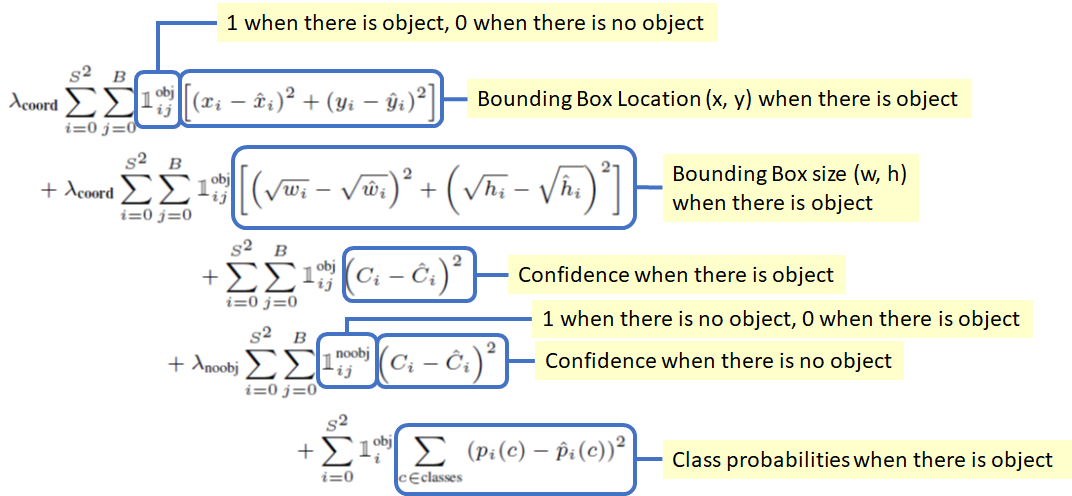

In [6]:
class YoloLoss(nn.Module):
  def __init__(self):
    super(YoloLoss, self).__init__()
    self.mse = nn.MSELoss()
    
  def forward(self, output, target):
    output = output.reshape(-1, S, S, C + B * 5)

    classes_probabilities_output = output[..., 10:]
    classes_probabilities_target = target[..., 5:]

    # calculate iou for both boxes
    iou_box1 = IOU(output[..., 1:5], target[..., 1:5])
    iou_box2 = IOU(output[..., 6:10], target[..., 1:5])
    
    # filters to see which bounding box is better
    better_box1 = (iou_box1 >= iou_box2) * 1
    better_box2 = torch.abs(better_box_1 - 1)

    # for each image get better box from cell
    predicted_box = better_box1 * output[..., 1:5] + better_box2 * output[..., 6:10]
    confidence = better_box1 * output[..., 0] + better_box2 * output[..., 5]

    # I only penalize if object exists in the cell
    exists_object_filter = (target[..., 0] == 1) * 1
    not_exists_object_filter = torch.abs(exists_object_filter - 1)
    box_targets = exists_object_filter * target[1:5]

    # ==========================
    # x, y, w, h part of loss
    # ==========================
    # derivative of sqrt(0) is going to be inifinity so we add SMOOTH
    # could be negative - use sign
    predicted_box = torch.sign(predicted_box) * torch.sqrt(
        torch.abs(predicted_box + SMOOTH)
    )
    box_targets = torch.sqrt(box_targets)

    # (N, S, S, 4) -> (N*S*S, 4)
    box_loss = LAMBDA_COORD * self.mse(
        torch.flatten(predicted_box, end_dim=-2),
        torch.flatten(box_targets, end_dim=-2)
    )
    # (N*S*S, 4) -> (N*S*S)
    loss = box_loss.sum(axis=1)

    # ==========================
    # object loss (confidence)
    # ==========================
    # (N, S, S, 1) -> (N*S*S)
    object_loss = self.mse(
        torch.flatten(exists_object_filter * confidence),
        torch.flatten(exists_object_filter)
    )
    loss += object_loss

    # ==========================
    # no object loss (confidence)
    # ==========================

    no_object_loss = LAMDA_NOOBJ * self.mse(
        torch.flatten(not_exists_object_filter * confidence),
        torch.flatten(not_exists_object_filter)
    )
    loss += no_object_loss

    # ==========================
    # class probabilities loss
    # ==========================
    # (N, S, S, 4) -> (N*S*S, 20)
    class_loss = self.mse(
        torch.flatten(exists_object_filter * classes_probabilities_output, end_dim=-2),
        torch.flatten(exists_object_filter * classes_probabilities_target, end_dim=-2)
    )
    loss += class_loss.sum(axis=1)

    return loss
    
    


In [ ]:
# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = ...
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    # enumerate epochs
    for epoch in range(EPOCHS):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()